In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
from dateutil.relativedelta import relativedelta
from typing import Dict, List, Tuple, Optional, Set
import warnings
warnings.filterwarnings("ignore")

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller

try:
    from statsmodels.stats.multitest import multipletests
    _HAS_BH = True
except Exception:
    _HAS_BH = False

try:
    from tqdm import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

import matplotlib.pyplot as plt

### 데이터 불러오기

In [ ]:
sp500 = pd.read_csv("sp500_return.csv", parse_dates=['date'], index_col=0)
sp500_list = pd.read_csv("sp500_list.csv", index_col=0, parse_dates=['start','ending'])
stock_id = pd.read_csv("stock_id.csv", index_col=0, parse_dates=['namedt','nameendt'])

sp500 = sp500.loc["1960-01-01":"1975-12-31"]
sp500.columns = sp500.columns.astype(int)

orders = pd.DataFrame(index=sp500.index, columns=sp500.columns, data=0, dtype=float)
sp500_prices = (1+sp500).cumprod()

comnam_map = stock_id[["namedt", "permno", "comnam"]].drop_duplicates().groupby(["permno"])["comnam"].last()

In [ ]:
# Formation / Test
FORMATION_MONTHS   = 12   # 포메이션 12개월
TEST_MONTHS        = 6    # 테스트 6개월
TEST_START_DATE    = pd.Timestamp("1961-01-01")
TEST_END_DATE      = pd.Timestamp("1975-12-31")

# Z-score & Trading
ROLL_Z             = 60   # Z-score 롤링 창(일수)
K_IN               = 2.0  # 진입 임계값(|z| >= 2)
K_OUT              = 0.5  # 청산 임계값(|z| <= 0.5)
K_STOP             = 4.0  # 손절 임계값(|z| >= 4)
MIN_HOLD_DAYS      = 3
COOLDOWN_DAYS      = 2

# Pair selection
TOP_N_PAIRS        = 3         # 테스트 구간에 사용할 상위 페어 수
PVALUE_MAX         = 0.05      # ADF 유의수준(공적분 판정)
MIN_OBS_PAIR       = 120       # 포메이션 구간 최소 표본
TOPK_CORR          = 40        # 상관계수 상위 K 후보만 공적분 필터링

# Portfolio constraints
MAX_GROSS_LEV      = 1.0       # 일일 총 노출 합계(|w| 합) ≤ 1
PAIR_WEIGHT_CAP    = 0.5       # 페어당 목표 총노출 캡

# Costs
COST_BPS           = 10        # 1방향 수수료
SLIPPAGE_BPS       = 5         # 1방향 슬리피지
BPS                = 1e-4

np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

### Cointegration + Z-scoring 전략

In [ ]:
# ---------------- Utilities ----------------
def fit_ols(x: pd.Series, y: pd.Series):

    _df = pd.concat([x, y], axis=1).dropna()
    if _df.shape[0] < 10:
        return None
    X = add_constant(_df.iloc[:,0].values)
    model = OLS(_df.iloc[:,1].values, X).fit()
    a = float(model.params[0]); b = float(model.params[1])
    resid = _df.iloc[:,1] - (a + b * _df.iloc[:,0])
    resid.index = _df.index
    return a, b, resid

def adf_pvalue(series: pd.Series) -> float:
    s = series.dropna().values
    if len(s) < 20:
        return 1.0
    try:
        return float(adfuller(s, autolag="AIC")[1])
    except Exception:
        return 1.0

def half_life(resid: pd.Series) -> float:
    z = resid.dropna()
    if len(z) < 30:
        return np.inf
    dz = z.diff().dropna()
    z1 = z.shift(1).dropna().reindex(dz.index)
    X = add_constant(z1.values)
    try:
        phi = OLS(dz.values, X).fit().params[1]
        if phi >= 1:
            return np.inf
        hl = np.log(2)/abs(np.log(max(1e-9, abs(phi))))
        return float(hl) if np.isfinite(hl) and hl > 0 else np.inf
    except Exception:
        return np.inf

def rolling_zscore(x: pd.Series, roll: int) -> pd.Series:
    m = x.rolling(roll, min_periods=roll).mean()
    s = x.rolling(roll, min_periods=roll).std(ddof=1)
    z = (x - m) / s
    return z.shift(1)  # 신호는 T-1 정보

def pair_position_from_z(z: float, beta: float, w_pair: float) -> Tuple[float,float]:
    if np.isnan(z):
        return 0.0, 0.0
    sign = -1.0 if z > 0 else 1.0  # z>0: spread가 + => Y short, X long
    wy = sign * (w_pair / (1.0 + abs(beta)))
    wx = -sign * (w_pair * abs(beta) / (1.0 + abs(beta)))
    return float(wy), float(wx)

def trade_cost(turnover_abs_notional: float, cost_bps=COST_BPS, slip_bps=SLIPPAGE_BPS) -> float:
    return turnover_abs_notional * (cost_bps + slip_bps) * BPS

def newey_west_tstat(x: pd.Series, max_lag: Optional[int] = None) -> Tuple[float, float]:
    r = x.dropna().values
    n = len(r)
    if n < 20:
        return np.nan, np.nan
    if max_lag is None:
        max_lag = int(np.floor(4.0 * (n/100.0)**(2.0/9.0)))
    max_lag = max(1, max_lag)
    r = r - r.mean()
    gamma0 = np.dot(r, r) / n
    lrv = gamma0
    for k in range(1, max_lag+1):
        w = 1.0 - k/(max_lag+1.0)
        cov = np.dot(r[:-k], r[k:]) / n
        lrv += 2.0 * w * cov
    se = np.sqrt(lrv / n)
    t = (x.mean()) / se if se > 0 else np.nan
    return float(t), float(se)


def stationary_bootstrap_mean_pvalue(x, B=3000, p=1/25):
    rng = np.random.default_rng(123)
    r = x.dropna().values
    n = len(r)
    if n < 30: return np.nan
    mu_hat = r.mean()
   
    s = r.std(ddof=1)
    t_obs = np.sqrt(n) * (mu_hat) / (s if s>0 else np.inf)
    boots = []
    for _ in range(B):
        idx=[]; i=rng.integers(0,n)
        for _ in range(n):
            idx.append(i)
            i = rng.integers(0,n) if rng.random()<p else (i+1)%n
        rb = r[idx]
        tb = np.sqrt(n)*(rb.mean())/(rb.std(ddof=1) if rb.std(ddof=1)>0 else np.inf)
        boots.append(tb)
    boots = np.array(boots)
    pval = 2*np.mean(np.abs(boots) >= np.abs(t_obs))
    return float(pval)

In [ ]:
# ---------------- Corr Top-K Candidate Builder ----------------
def build_topk_corr_candidates(form_px: pd.DataFrame, topk: int = TOPK_CORR) -> Set[Tuple[int,int]]:

    # 포메이션 구간에서 로그수익률의 |상관계수| 기준 상위 topk 후보쌍을 구성.
    log_form = np.log(form_px).replace([np.inf, -np.inf], np.nan).dropna(how='any', axis=1)
    if log_form.shape[1] < 2:
        return set()
    # 로그수익률
    ret_form = log_form.diff().dropna()
    # 결측/상수열 제거 방지용
    valid_cols = ret_form.columns[ret_form.std() > 0]
    ret_form = ret_form[valid_cols]
    if ret_form.shape[1] < 2:
        return set()

    corr = ret_form.corr().abs()  # 절대값 기준
    candidates: Set[Tuple[int,int]] = set()
    cols = corr.columns.tolist()

    for y in cols:
        # 자기 자신 제외 후 상위 topk
        s = corr[y].drop(index=y).sort_values(ascending=False)
        top = s.head(topk).index.astype(int).tolist()
        y_int = int(y)
        for x_int in top:
            a, b = (min(y_int, x_int), max(y_int, x_int))
            candidates.add((a, b))
    return candidates

# ---------------- Pair Selection (with Corr Top-K filter) ----------------
def select_pairs_by_formation(
    form_px: pd.DataFrame,
    candidates: Set[Tuple[int,int]],
    pval_max=PVALUE_MAX,
    min_obs=MIN_OBS_PAIR,
    top_n=TOP_N_PAIRS
) -> pd.DataFrame:

    log_form = np.log(form_px).replace([np.inf, -np.inf], np.nan).dropna(how='any', axis=1)
    if log_form.shape[1] < 2:
        return pd.DataFrame(columns=["Y","X","alpha","beta","adf_p","half_life","n_obs","pval_adj","score"])

    available = set(map(int, log_form.columns))
    recs = []

    for (a, b) in candidates:
        # 데이터에 둘 다 있어야 함
        if a not in available or b not in available:
            continue
        yi, xi = a, b
        xy = pd.concat([log_form[yi], log_form[xi]], axis=1).dropna()
        if len(xy) < min_obs:
            continue
        # y = yi, x = xi
        res = fit_ols(xy.iloc[:,1], xy.iloc[:,0])
        if res is None:
            continue
        alpha, beta, resid = res
        pval = adf_pvalue(resid)
        hl = half_life(resid)
        recs.append([yi, xi, alpha, beta, pval, hl, len(xy)])

    if len(recs) == 0:
        return pd.DataFrame(columns=["Y","X","alpha","beta","adf_p","half_life","n_obs","pval_adj","score"])

    df = pd.DataFrame(recs, columns=["Y","X","alpha","beta","adf_p","half_life","n_obs"])
    # FDR(BH) 보정
    if _HAS_BH and len(df) > 1:
        _, p_adj, _, _ = multipletests(df["adf_p"].values, alpha=pval_max, method="fdr_bh")
        df["pval_adj"] = p_adj
    else:
        df["pval_adj"] = df["adf_p"].values

    df = df[df["pval_adj"] <= pval_max].copy()
    if df.empty:
        return df.assign(score=np.nan)

    # 점수: p-value 작을수록, half-life 짧을수록 우수
    df["score"] = (-np.log(df["pval_adj"] + 1e-12)) / (1.0 + df["half_life"].clip(lower=1.0))
    df = df.sort_values(["score","n_obs"], ascending=[False, False]).head(top_n).reset_index(drop=True)
    return df

In [ ]:
# ---------------- Backtest Single Pair ----------------
def backtest_single_pair(
    test_px: pd.DataFrame,
    y: int, x: int, alpha: float, beta: float,
    roll=ROLL_Z, k_in=K_IN, k_out=K_OUT, k_stop=K_STOP,
    min_hold=MIN_HOLD_DAYS, cooldown=COOLDOWN_DAYS
) -> pd.DataFrame:
    lt = np.log(test_px[[y, x]]).replace([np.inf, -np.inf], np.nan).dropna()
    if lt.shape[0] < roll + 5:
        return pd.DataFrame()
    idx = lt.index
    spread = lt[y] - (alpha + beta * lt[x])
    z = rolling_zscore(spread, roll=roll)

    y_w = pd.Series(0.0, index=idx)
    x_w = pd.Series(0.0, index=idx)
    holding = 0   # 0: none, 1: long spread, -1: short spread
    hold_days = 0
    cool_left = 0

    for t, day in enumerate(idx):
        if cool_left > 0:
            y_w.iloc[t] = 0.0; x_w.iloc[t] = 0.0
            cool_left -= 1
            continue

        zt = z.iloc[t]

        # 보유 중: 손절/청산/유지
        if holding != 0:
            if abs(zt) >= k_stop:
                holding = 0
                y_w.iloc[t] = 0.0; x_w.iloc[t] = 0.0
                cool_left = cooldown
                hold_days = 0
                continue
            if hold_days >= min_hold and abs(zt) <= k_out:
                holding = 0
                y_w.iloc[t] = 0.0; x_w.iloc[t] = 0.0
                cool_left = cooldown
                hold_days = 0
                continue
            # 유지 (부호만 유지, 크기는 1 총노출 기준)
            wy, wx = pair_position_from_z(1.0 if holding>0 else -1.0, beta, w_pair=1.0)
            y_w.iloc[t] = wy; x_w.iloc[t] = wx
            hold_days += 1
            continue

        # 신규 진입
        if not np.isnan(zt) and abs(zt) >= k_in:
            holding = -1 if zt > 0 else 1
            hold_days = 1
            wy, wx = pair_position_from_z(zt, beta, w_pair=1.0)
            y_w.iloc[t] = wy; x_w.iloc[t] = wx
        else:
            y_w.iloc[t] = 0.0; x_w.iloc[t] = 0.0

    detail = pd.DataFrame({
        "y_w_raw": y_w, "x_w_raw": x_w,
        "z": z.reindex(idx), "spread": spread.reindex(idx)
    })
    return detail

# ---------------- Walk-Forward Runner ----------------
def run_walk_forward(px_all: pd.DataFrame) -> Dict[str, pd.Series]:
    px_all = px_all.sort_index()
    rets_all = px_all.pct_change().fillna(0.0)

    port_ret_list = []
    turnover_list = []

    steps = []
    cur_start = TEST_START_DATE
    while True:
        form_start = (cur_start - relativedelta(months=FORMATION_MONTHS))
        form_end   = cur_start - pd.Timedelta(days=1)
        test_start = cur_start
        test_end   = min(test_start + relativedelta(months=TEST_MONTHS) - pd.Timedelta(days=1), TEST_END_DATE)
        if test_start > TEST_END_DATE:
            break
        steps.append((form_start, form_end, test_start, test_end))
        cur_start = test_end + pd.Timedelta(days=1)

    iterator = tqdm(steps, desc="Walk-Forward") if _HAS_TQDM else steps
    prev_w = None  # turnover 계산용

    for (form_start, form_end, test_start, test_end) in iterator:
        form_px = px_all.loc[form_start:form_end]
        test_px = px_all.loc[test_start:test_end]
        if form_px.shape[0] < MIN_OBS_PAIR or test_px.shape[0] < 20:
            continue

        # 1) Corr Top-K 후보 구축
        candidates = build_topk_corr_candidates(form_px, topk=TOPK_CORR)
        if len(candidates) == 0:
            continue

        # 2) Corr Top-K 후보에 한해 공적분 필터
        pairs = select_pairs_by_formation(
            form_px,
            candidates=candidates,
            pval_max=PVALUE_MAX,
            min_obs=MIN_OBS_PAIR,
            top_n=TOP_N_PAIRS
        )
        if pairs.empty:
            continue

        # 3) 각 페어 원시 가중치 궤적
        detail_map = {}
        for _, row in pairs.iterrows():
            y, x = int(row["Y"]), int(row["X"])
            alpha, beta = float(row["alpha"]), float(row["beta"])
            detail = backtest_single_pair(
                test_px, y, x, alpha, beta,
                roll=ROLL_Z, k_in=K_IN, k_out=K_OUT, k_stop=K_STOP,
                min_hold=MIN_HOLD_DAYS, cooldown=COOLDOWN_DAYS
            )
            if not detail.empty:
                detail_map[(y,x)] = detail
        if len(detail_map) == 0:
            continue

        # 4) 포트 구성: 페어당 목표 총노출 = min(MAX_GROSS_LEV/num_pairs, PAIR_WEIGHT_CAP)
        all_days = test_px.index
        tgt_per_pair = min(MAX_GROSS_LEV / max(1, len(detail_map)), PAIR_WEIGHT_CAP)
        w_df = pd.DataFrame(0.0, index=all_days, columns=[])

        for (y,x), det in detail_map.items():
            wy_raw = det["y_w_raw"].reindex(all_days).fillna(0.0)
            wx_raw = det["x_w_raw"].reindex(all_days).fillna(0.0)
            gross_raw = (wy_raw.abs() + wx_raw.abs()).replace(0.0, np.nan)
            scale = (tgt_per_pair / gross_raw).clip(upper=1.0).fillna(0.0)
            w_df[(y,"Y")] = wy_raw * scale
            w_df[(x,"X")] = wx_raw * scale

        # 5) 일일 레버리지 캡 (총 |w| 합 ≤ MAX_GROSS_LEV)
        gross = w_df.abs().sum(axis=1)
        scale = (MAX_GROSS_LEV / gross).clip(upper=1.0).fillna(1.0)
        w_df = (w_df.T * scale.values).T

        # 6) 일별 PnL/Turnover (거래비용 포함)
        total_ret = pd.Series(0.0, index=all_days)
        total_tov = pd.Series(0.0, index=all_days)

        if prev_w is None:
            prev_w = pd.Series(0.0, index=w_df.columns)

        for day in all_days:
            day_w = w_df.loc[day]
            # turnover: 절대 포지션 변화의 합
            aligned = prev_w.reindex(day_w.index).fillna(0.0)
            tov = float((day_w - aligned).abs().sum())
            cost = trade_cost(tov, COST_BPS, SLIPPAGE_BPS)

            r_day = 0.0
            for (permno, leg), w_ in day_w.items():
                if permno in rets_all.columns:
                    r_day += w_ * float(rets_all.loc[day, permno])

            total_ret.loc[day] = r_day - cost
            total_tov.loc[day] = tov
            prev_w = day_w

        port_ret_list.append(total_ret)
        turnover_list.append(total_tov)

    if len(port_ret_list) == 0:
        raise ValueError("백테스트 결과가 없습니다. (선정 페어 없음/데이터 부족)")

    port_ret = pd.concat(port_ret_list, axis=0).sort_index()
    turnover = pd.concat(turnover_list, axis=0).sort_index()

    port_ret = port_ret.loc[(port_ret.index >= TEST_START_DATE) & (port_ret.index <= TEST_END_DATE)]
    turnover = turnover.reindex(port_ret.index).fillna(0.0)
    return {"ret": port_ret, "turnover": turnover}


### 성과 분석

Walk-Forward: 100%|██████████| 30/30 [2:59:15<00:00, 358.50s/it]



===== Performance Summary =====
 Terminal Equity: 0.511346752569944
            CAGR: -0.04403646026315422
        Ann.Mean: -0.0435869155675486
         Ann.Vol: 0.05370516159809422
          Sharpe: -0.8115963954029947
           MaxDD: -0.4929110431232787
           Ndays: 3753

===== Significance (Mean of Daily Returns) =====
Newey-West t-stat : -3.542 (SE=0.000049)
Stationary Bootstrap p-value (two-sided): 0.9853


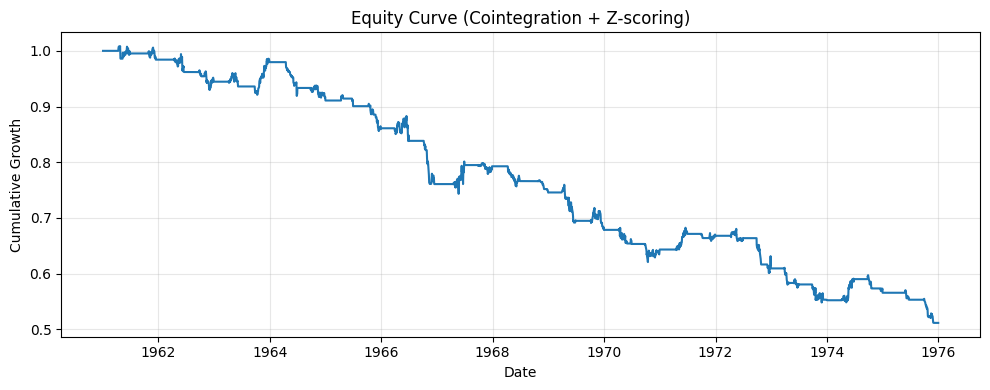

In [ ]:
# ---------------- Performance & Plot ----------------
def perf_summary(ret: pd.Series, periods_per_year=252) -> Dict[str, float]:
    r = ret.dropna()
    if len(r) == 0:
        return {}
    eq = (1+r).cumprod()
    mu = r.mean() * periods_per_year
    vol = r.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = mu/vol if vol>0 else np.nan
    dd = (eq/eq.cummax()-1).min()
    return {
        "Terminal Equity": float(eq.iloc[-1]),
        "CAGR": float(eq.iloc[-1]**(periods_per_year/len(r)) - 1.0),
        "Ann.Mean": float(mu),
        "Ann.Vol": float(vol),
        "Sharpe": float(sharpe),
        "MaxDD": float(dd),
        "Ndays": int(len(r))
    }

def finalize_and_test(port_ret: pd.Series):
    summ = perf_summary(port_ret)
    print("\n===== Performance Summary =====")
    for k,v in summ.items():
        print(f"{k:>16s}: {v}")

    t_nw, se_nw = newey_west_tstat(port_ret)
    p_boot = stationary_bootstrap_mean_pvalue(port_ret, B=3000, p=1/25)
    print("\n===== Significance (Mean of Daily Returns) =====")
    print(f"Newey-West t-stat : {t_nw:.3f} (SE={se_nw:.6f})")
    print(f"Stationary Bootstrap p-value (two-sided): {p_boot:.4f}")

    # --- Plot equity curve ---
    eq = (1+port_ret.fillna(0.0)).cumprod()
    plt.figure(figsize=(10,4))
    plt.plot(eq.index, eq.values)
    plt.title("Equity Curve (Cointegration + Z-scoring)")
    plt.xlabel("Date"); plt.ylabel("Cumulative Growth")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 백테스트에 필요한 구간만 잘라서 전달(포메이션 시작까지 포함)
px_needed_start = TEST_START_DATE - relativedelta(months=FORMATION_MONTHS) - pd.Timedelta(days=5)
px_all = sp500_prices.loc[px_needed_start:TEST_END_DATE].copy()

results = run_walk_forward(px_all)
ret = results["ret"]
turnover = results["turnover"]

finalize_and_test(ret)